In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


In [13]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'])

id
station
name
latitude
longitude
elevation


# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


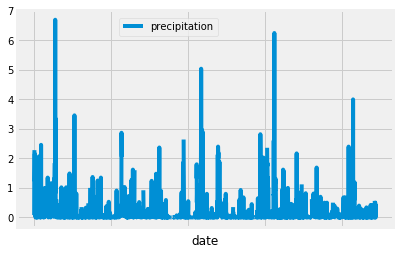

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)
# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)
# Sort the dataframe by date
precip_df = precip_df.sort_values('date', ascending=True)
precip_df.set_index('date')
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot('date','prcp', label='precipitation')
plt.legend(loc=(.27,.88))

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement).group_by(Measurement.station).count()
print(f"{station_count} stations")

9 stations


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).all()
for station, count in station_active:
    print(f"Station {station} had {count} weather observations")

Station USC00519281 had 2772 weather observations
Station USC00519397 had 2724 weather observations
Station USC00513117 had 2709 weather observations
Station USC00519523 had 2669 weather observations
Station USC00516128 had 2612 weather observations
Station USC00514830 had 2202 weather observations
Station USC00511918 had 1979 weather observations
Station USC00517948 had 1372 weather observations
Station USC00518838 had 511 weather observations


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature from the most active station?
busiest = station_active[0][0]
low_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
                filter(Measurement.station == busiest).all()
high_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
                filter(Measurement.station == busiest).all()
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
                filter(Measurement.station == busiest).all()
temp_list = [low_temp, high_temp, avg_temp]
print("The highest, lowest, and average temperatures recorded at this station (respectively) are:")
for item in temp_list:
    for station, temp in item:
        print("%.2f" % temp) # Rounds to two decimal places

The highest, lowest, and average temperatures recorded at this station (respectively) are:
54.00
85.00
71.66


Text(0,0.5,'Frequency')

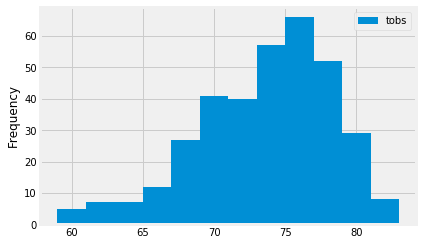

In [19]:
# Choose the station with the highest number of temperature observations.
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == busiest).\
                    filter(Measurement.date > last_year).all()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df = pd.DataFrame(temperature)
plt.hist(temp_df['tobs'], 12)
plt.legend(["tobs"])
plt.ylabel('Frequency')

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
date_arrive = dt.date(2018, 1, 1)
date_depart = dt.date(2018, 1, 7)
year_ago = dt.timedelta(days=365)
avg_temp_year_ago = calc_temps(date_arrive - year_ago, date_depart - year_ago)
print(avg_temp_year_ago)

[(62.0, 68.36585365853658, 74.0)]


Text(0,0.5,'Temp(F)')

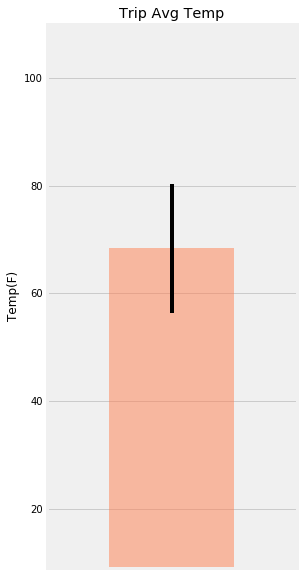

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
TMIN = avg_temp_year_ago[0][0]
TAVE = avg_temp_year_ago[0][1]
TMAX = avg_temp_year_ago[0][2]
plt.figure(figsize=(4,10))
plt.bar(1, TAVE, color = 'coral', yerr = TMAX-TMIN, width = 0.2, alpha = 0.5)
plt.xticks([])  #hides x axis label
plt.xlim(.8, 1.2)
plt.ylim(9,110)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
combined_station = session.query(*sel).filter(Measurement.station == Station.station).\
                        filter(Measurement.date.between((date_arrive-year_ago),(date_depart-year_ago))).\
                        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
combined_station
for record in combined_station:
    (station, name, lat, lon, elevation, total) = record
    print(f"It rained {total} inches at station {station} in {name} ({lat}, {lon}) at an elevation of {elevation} feet")


It rained 0.61 inches at station USC00519523 in WAIMANALO EXPERIMENTAL FARM, HI US (21.33556, -157.71139) at an elevation of 19.5 feet
It rained 0.6 inches at station USC00514830 in KUALOA RANCH HEADQUARTERS 886.9, HI US (21.5213, -157.8374) at an elevation of 7.0 feet
It rained 0.6 inches at station USC00516128 in MANOA LYON ARBO 785.2, HI US (21.3331, -157.8025) at an elevation of 152.4 feet
It rained 0.35 inches at station USC00513117 in KANEOHE 838.1, HI US (21.4234, -157.8015) at an elevation of 14.6 feet
It rained 0.2 inches at station USC00519281 in WAIHEE 837.5, HI US (21.45167, -157.84888999999998) at an elevation of 32.9 feet
It rained 0.0 inches at station USC00519397 in WAIKIKI 717.2, HI US (21.2716, -157.8168) at an elevation of 3.0 feet


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = date_arrive-year_ago
end_date = date_depart-year_ago
# Use the start and end date to create a range of dates
date_query = session.query(Measurement.date).filter(Measurement.date.between(start_date,end_date)).\
                group_by(Measurement.date).all()
# Stip off the year and save a list of %m-%d strings
stripped_dates = [x[5:] for x in [x[0] for x in date_query]]
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = []
for date in stripped_dates:
    daily_norms.append(daily_normals(date))

# Unnest daily_norms list to be able to turn into Data Frame
filter_norms = []
for i in range(7):
    filter_norms.append(daily_norms[i][0])
    i+=1
filter_norms

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(filter_norms, columns =['Min Temp', 'Avg Temp', 'Max Temp'])
daily_norms_df['Date'] = [x[0] for x in date_query]
daily_norms_df.set_index('Date', inplace=True)
daily_norms_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


Text(0.5,1,'Aggregate Daily Normals for Trip Dates')

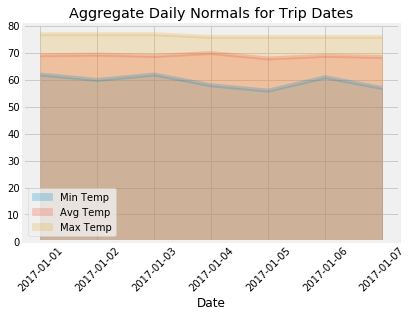

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', alpha = 0.25, stacked=False)
tick_locations = range(7)
plt.xticks(tick_locations, [x[0] for x in date_query], rotation=45)
plt.title('Aggregate Daily Normals for Trip Dates')